# Data exploration

We have 5 rice varieties in our image data, Arborio, Basmati, Ipsala, Jasmine, and Karacadag. The total number of the images is 75,000. Each of the varieties has 15,000 images from different angles and sizes. The image sizes are all 250x250 pixels, but the sizes of each rice are different. Every image is in a dark background with exactly one rice in the middle of the image. We will look at this image and use OpenCV to get the feature from those image datasets. The features we will extract are displayed in the next cell.

# The feature and explanations extract from the image datasets

In [ ]:
import pandas as pd
from IPython.display import display, HTML

In [ ]:
data = {
    "Variable Name": ["Area", "Perimeter", "Major_Axis_Length", "Minor_Axis_Length", "Eccentricity", "Convex_Area", "Extent"],
    "Role": ["Feature", "Feature", "Feature", "Feature", "Feature", "Feature", "Feature"],
    "Type": ["Integer", "Continuous", "Continuous", "Continuous", "Continuous", "Integer", "Continuous"],
    "Description": [
        "Returns the number of pixels within the boundaries of the rice grain",
        "Calculates the circumference by calculating the distance between pixels around the boundaries of the rice grain",
        "The longest line that can be drawn on the rice grain, i.e. the main axis distance",
        "The shortest line that can be drawn on the rice grain, i.e. the small axis distance",
        "It measures how round the ellipse, which has the same moments as the rice grain",
        "Returns the pixel count of the smallest convex shell of the region formed by the rice grain",
        "Returns the ratio of the region formed by the rice grain to the bounding box pixels"
    ]
}
df = pd.DataFrame(data)
display(HTML(df.to_html(index=False)))

Variable Name,Role,Type,Description
Area,Feature,Integer,Returns the number of pixels within the boundaries of the rice grain
Perimeter,Feature,Continuous,Calculates the circumference by calculating the distance between pixels around the boundaries of the rice grain
Major_Axis_Length,Feature,Continuous,"The longest line that can be drawn on the rice grain, i.e. the main axis distance"
Minor_Axis_Length,Feature,Continuous,"The shortest line that can be drawn on the rice grain, i.e. the small axis distance"
Eccentricity,Feature,Continuous,"It measures how round the ellipse, which has the same moments as the rice grain"
Convex_Area,Feature,Integer,Returns the pixel count of the smallest convex shell of the region formed by the rice grain
Extent,Feature,Continuous,Returns the ratio of the region formed by the rice grain to the bounding box pixels


# Retrieve the data

In [ ]:
!git lfs install
!git clone https://huggingface.co/datasets/nateraw/rice-image-dataset
!unzip /content/rice-image-dataset/rice-image-dataset.zip -d /content/rice-image-dataset/

Git LFS initialized.
fatal: destination path 'rice-image-dataset' already exists and is not an empty directory.
Archive:  /content/rice-image-dataset/rice-image-dataset.zip
replace /content/rice-image-dataset/Rice_Image_Dataset/Arborio/Arborio (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/rice-image-dataset/Rice_Image_Dataset/Arborio/Arborio (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/rice-image-dataset/Rice_Image_Dataset/Arborio/Arborio (100).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# install opencv and pandas (colab notebook already install)

In [ ]:
!pip install opencv-python-headless pandas

# Getting the features from image

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Extract the features from the given image
# param image_path: The image path
# return: The list of data for each feature
def extract_features(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Check if the image is loaded successfully
    if image is None:
        print(f"Failed to load image: {image_path}")
        return []

    # Binary thresholding
    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Show the original image and contours
    #image_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    #cv2.drawContours(image_contours, contours, -1, (0, 255, 0), 2)
    #plt.imshow(image_contours)
    #plt.title("Contours")
    #plt.show()

    # Initialize feature list
    features_list = []

    for contour in contours:
        # Calculate features
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        x, y, w, h = cv2.boundingRect(contour)
        major_axis_length = max(w, h)
        minor_axis_length = min(w, h)
        eccentricity = 0  # Default value for eccentricity
        if len(contour) >= 5:  # fitEllipse needs at least 5 points
            (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
            if MA < ma:
              MA, ma = ma, MA
            if MA > 0 and ma > 0:
              eccentricity = np.sqrt(1 - (ma/MA)**2)
        hull = cv2.convexHull(contour)
        convex_area = cv2.contourArea(hull)
        extent = area / (w * h) if w * h > 0 else 0

        # Append features to list
        features = [area, perimeter, major_axis_length, minor_axis_length, eccentricity, convex_area, extent]
        features_list.append(features)

    return features_list

In [ ]:
# Define the main directory path
main_directory_path = '/content/rice-image-dataset/Rice_Image_Dataset'

# Get all class subdirectories
classes = os.listdir(main_directory_path)
classes.remove('Rice_Citation_Request.txt')
all_features = []

# Iterate through each class subdirectory
for class_name in classes:
    class_path = os.path.join(main_directory_path, class_name)
    if os.path.isdir(class_path):
        # Get all image files in the class directory
        for filename in os.listdir(class_path):
            if filename.endswith(".png") or filename.endswith(".jpg"):
                image_path = os.path.join(class_path, filename)
                features = extract_features(image_path)
                if features:
                    all_features.extend(features)

# Initialize DataFrame
columns = ["Area", "Perimeter", "Major_Axis_Length", "Minor_Axis_Length", "Eccentricity", "Convex_Area", "Extent"]
df = pd.DataFrame(all_features, columns=columns)

# Drop rows with NaN values
df = df.dropna()

# Add additional columns
df['Variable Name'] = ["Feature"] * len(df)
df['Role'] = ["Feature"] * len(df)
df['Type'] = ["Continuous"] * len(df)
df['Description'] = [""] * len(df)
df['Units'] = [""] * len(df)
df['Missing Values'] = ["no"] * len(df)

# Rearrange column order
df = df[["Area", "Perimeter", "Major_Axis_Length", "Minor_Axis_Length", "Eccentricity", "Convex_Area", "Extent"]]


In [ ]:
# Display the DataFrame
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',504)
pd.set_option('display.width', 1000)
print(df)

         Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  Convex_Area    Extent
0      7759.5  368.433545                129                 95      0.871521       7916.5  0.633170
1      7310.0  355.847760                116                101      0.853411       7472.0  0.623933
2      7077.5  352.977702                141                 69      0.880521       7194.0  0.727464
3      7902.5  370.007140                145                 71      0.856832       8096.5  0.767606
4      9045.0  389.220344                153                 77      0.842469       9188.0  0.767762
...       ...         ...                ...                ...           ...          ...       ...
74995  6491.5  416.457931                151                114      0.970554       6764.5  0.377106
74996  6811.0  403.244727                153                101      0.962931       6950.0  0.440756
74997  6958.0  442.274166                175                 94      0.976012       7161.5 

In [ ]:
# Count the number of classes and images
num_classes = len(classes)
num_images = len(all_features)

print(f"Number of classes: {num_classes}")
print(f"Number of images: {num_images}")

Number of classes: 5
Number of images: 75000


# Example image for each rice varieties

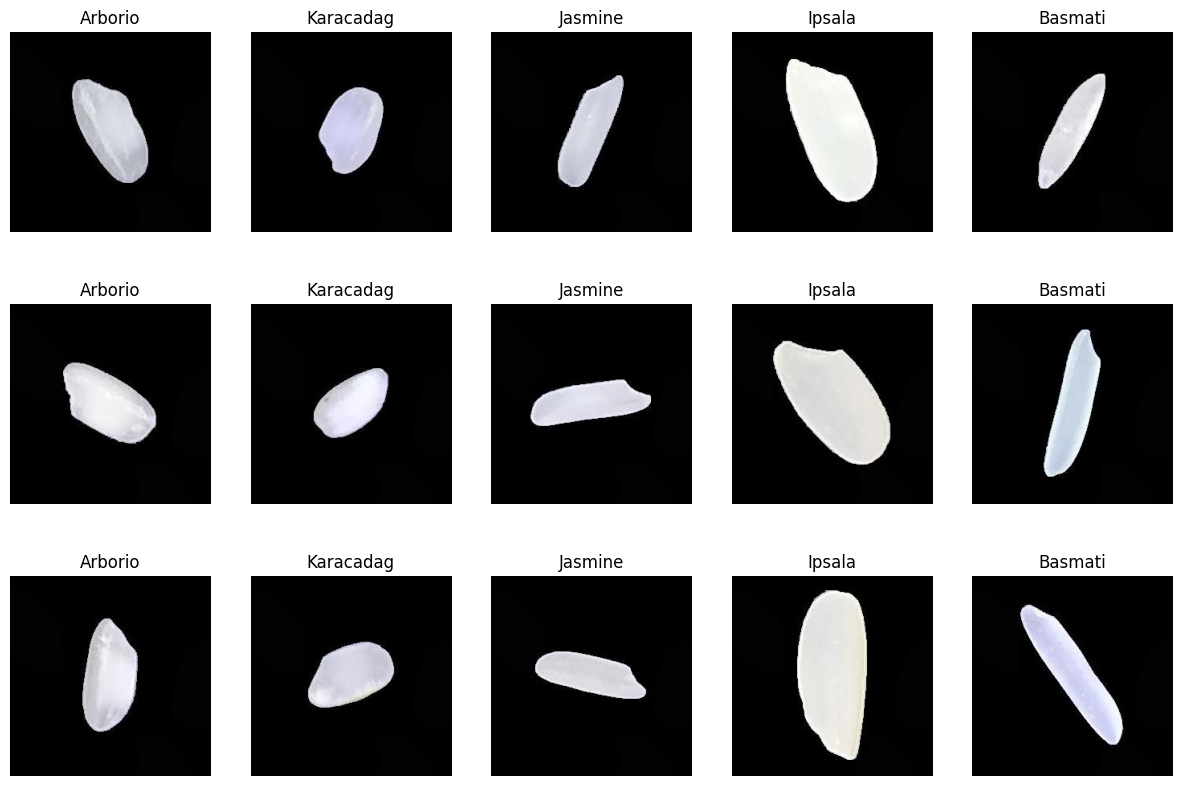

In [ ]:
# Plot three images for each variety
fig, axs = plt.subplots(3, len(classes), figsize=(15, 10))

for i, class_name in enumerate(classes):
    class_path = os.path.join(main_directory_path, class_name)
    if os.path.isdir(class_path):
        image_paths = os.listdir(class_path)[:3]
        for j, image_path in enumerate(image_paths):
            image_path = os.path.join(class_path, image_path)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Plot the image
            axs[j, i].imshow(image, cmap='gray')
            axs[j, i].set_title(class_name)
            axs[j, i].axis('off')

plt.show()

# Data Exploration

               Area     Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity   Convex_Area        Extent
count  75000.000000  75000.000000       75000.000000       75000.000000  75000.000000  75000.000000  75000.000000
mean    8206.674293    398.497899         148.066867          91.670333      0.889055   8414.327127      0.619275
std     3092.094279     74.269905          33.308083          24.762705      0.072231   3162.466775      0.121558
min     3808.500000    277.521860          86.000000          37.000000      0.610742   3907.000000      0.271136
25%     6118.500000    333.379724         119.000000          75.000000      0.848184   6246.500000      0.548034
50%     7179.000000    370.232535         141.000000          88.000000      0.888345   7366.500000      0.642242
75%     8705.625000    468.835567         179.000000         105.000000      0.955154   8959.500000      0.711852
max    20740.000000    625.587875         242.000000         179.000000      0.989206  2

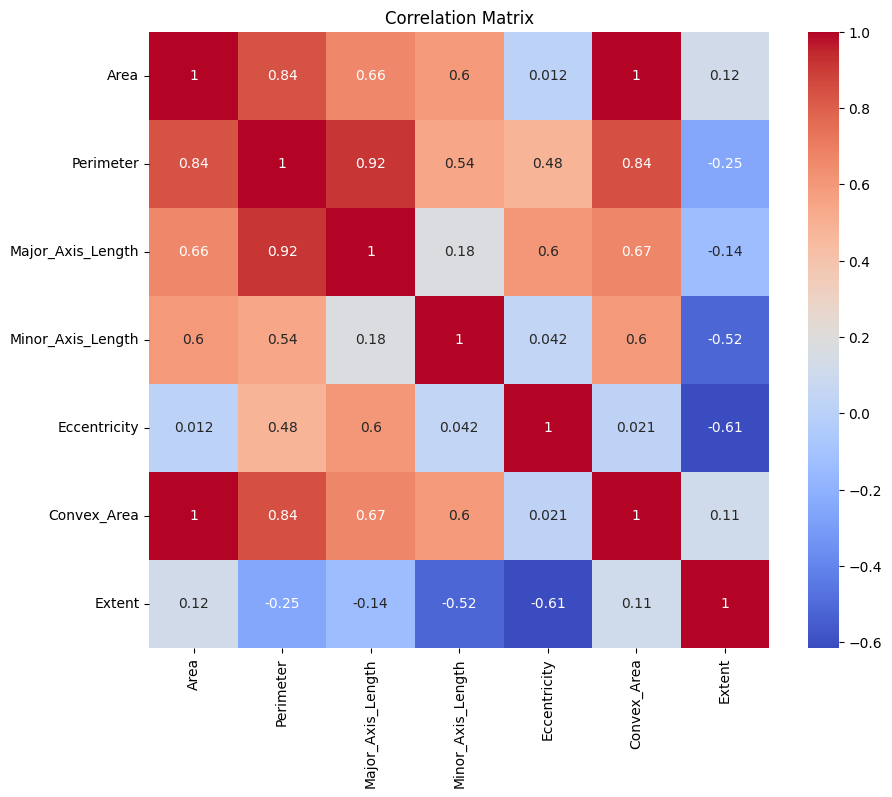

In [ ]:
import seaborn as sns

# View descriptive statistics
print(df.describe())

# Check the number of missing values ​​in each column
print(df.isnull().sum())

# Plotting a heatmap of the correlation matrix
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

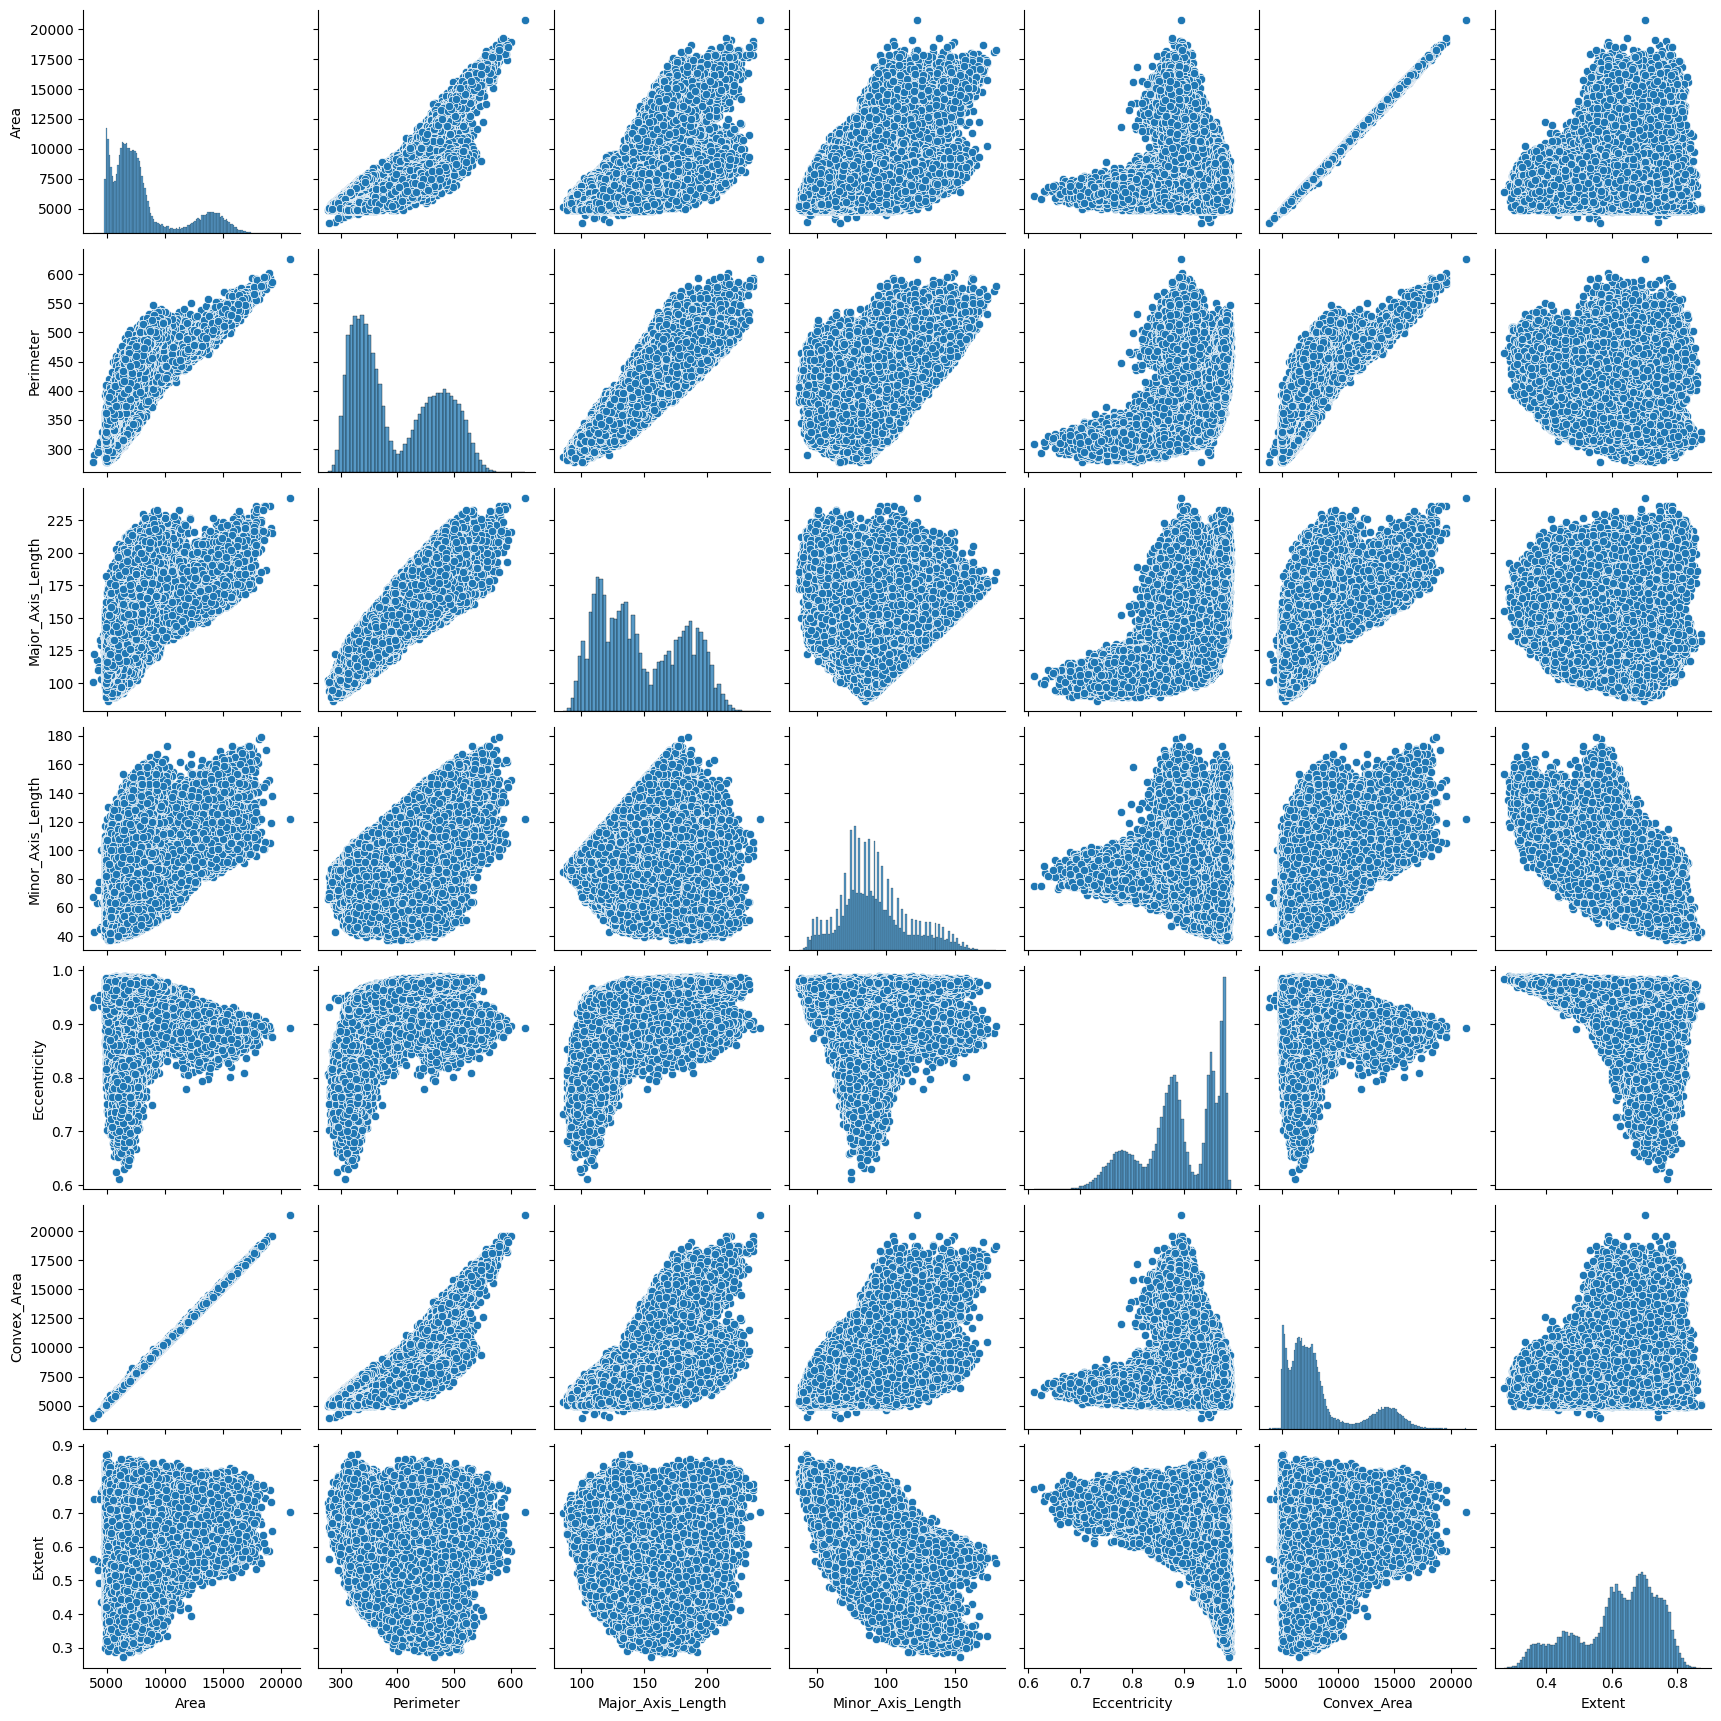

In [ ]:
#show pairplot
sns.pairplot(df)
plt.show()

# Preprocess the data
The process of preprocess the data will be in [README](https://github.com/Astraeven0502/CSE151A_Group_Project-Rice_Classification/blob/main/README.md)
